In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats# Data Preprocessing

#import numpy as np
#import pandas as pd

# Data Analysis
import plotly.express as px
import missingno as msno

# Feature Selection
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Data Modeling
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation & saving the model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score, precision_score, f1_score
import pickle
#from scipy.stats import chi2_contingency
#import plotly.express as px
#from imblearn.under_sampling import RandomUnderSampler
#from sklearn.model_selection import train_test_split

In [ ]:
# Loading dataset
data = pd.read_csv("/content/drive/MyDrive/Project/covid_data_2020-2021.csv")

In [ ]:
#Omitting rows with missing values
data.dropna(inplace = True)

#Dropping all rows where corona_result = Other to keep problem as binary classification
data.drop(data[data['corona_result'] == "Other"].index, inplace = True)

In [ ]:
data.to_csv("covid_data_2020-2021.csv", index=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5861480 entries, 0 to 5861479
Data columns (total 10 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   test_date            object
 1   cough                int64 
 2   fever                int64 
 3   sore_throat          int64 
 4   shortness_of_breath  int64 
 5   head_ache            int64 
 6   corona_result        object
 7   age_60_and_above     object
 8   gender               object
 9   test_indication      object
dtypes: int64(5), object(5)
memory usage: 620.9+ MB


In [ ]:
# Checking the levels for categorical features

def show(data):
  for i in data.columns[1:]:
    print("Feature: {} with {} Levels".format(i,data[i].unique()))

show(data)

Feature: cough with [0 1] Levels
Feature: fever with [0 1] Levels
Feature: sore_throat with [0 1] Levels
Feature: shortness_of_breath with [0 1] Levels
Feature: head_ache with [0 1] Levels
Feature: corona_result with ['Negative' 'Positive'] Levels
Feature: age_60_and_above with ['Yes' 'No'] Levels
Feature: gender with ['female' 'male'] Levels
Feature: test_indication with ['Other' 'Contact with confirmed' 'Abroad'] Levels


In [ ]:
# Checking for Null values
data.isnull().sum()

test_date              0
cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
corona_result          0
age_60_and_above       0
gender                 0
test_indication        0
dtype: int64

In [ ]:
# Label Encoding

data['corona_result'] = data['corona_result'].map({'Negative': 0, 'Positive': 1})
data['gender'] = data['gender'].map({'female': 0, 'male': 1})
data['age_60_and_above'] = data['age_60_and_above'].map({'No': 0, 'Yes': 1})

# One Hot Encoding 

data['test_indication'] = data['test_indication'].map({'Abroad': 'abroad', 'Contact with confirmed': 'contact_with_covid_positive_patient', 'Other': 'other'})
data = pd.get_dummies(data, columns = ['test_indication'])

# Renaming the encoded feature names & dropping test_indication_other & test_date feature

data.rename({'test_indication_abroad': 'abroad',
             'test_indication_contact_with_covid_positive_patient': 'contact_with_covid_positive_patient'},
             axis='columns', inplace = True)

data.drop(['test_date','test_indication_other'], axis = 1, inplace = True)
data.head()
#data.shape

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,abroad,contact_with_covid_positive_patient
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [ ]:
data.shape

(5861480, 10)

In [ ]:
# showing Correlation Map
fig = px.imshow(data.corr(),width=1000, height=600)
fig.show()

In [ ]:
#Feature extraction(# Creating feature risk coeficient)

data['risk_coef'] = data['cough']*0.1 + data['fever']*0.2 + data['sore_throat']*0.1 + data['shortness_of_breath']*0.1 + data['head_ache']*0.1 + data['age_60_and_above']*0.1 + data['abroad']*0.1 + data['contact_with_covid_positive_patient']*0.2
data.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,abroad,contact_with_covid_positive_patient,risk_coef
0,0,0,0,0,0,0,1,0,0,0,0.1
1,0,0,0,0,0,0,1,1,0,0,0.1
2,0,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,1,0,0,0,0.1
4,0,0,0,0,0,0,1,0,0,0,0.1


In [ ]:
# Removing all records with risk_coef >= 0.6 and corona_result = 0 and risk_coef <= 0.3 and corona_result = 1
i1 = data[(data['risk_coef'] >= 0.6) & (data['corona_result'] == 0)].index
i2 =data[(data['risk_coef'] <= 0.3) & (data['corona_result'] == 1)].index
data.drop(i1, inplace = True)
data.drop(i2, inplace = True)

# Dropping risk coeficient
data.drop(['risk_coef'], axis = 1, inplace = True)
data = data.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5499031 entries, 0 to 5861479
Data columns (total 10 columns):
 #   Column                               Dtype
---  ------                               -----
 0   cough                                int64
 1   fever                                int64
 2   sore_throat                          int64
 3   shortness_of_breath                  int64
 4   head_ache                            int64
 5   corona_result                        int64
 6   age_60_and_above                     int64
 7   gender                               int64
 8   abroad                               int64
 9   contact_with_covid_positive_patient  int64
dtypes: int64(10)
memory usage: 461.5 MB


In [ ]:
#feature selection
imp_var = []
h = dict()
u = dict()
unimp_var = []

# Creating a class for Chi Square Test

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None 
        self.chi2 = None 
        self.dof = None
        
        self.dfTabular = None
        self.dfExpected = None
    
    # Checking for level of significance 
    
    def _print_chisquare_result(self, colX, alpha):
        if self.p < alpha:
          h[colX] = self.p
        else:
          unimp_var.append(colX)
          u[colX] = self.p
            
    def TestIndependence(self, colX, colY, alpha = 0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y, X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns = self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX, alpha)

In [ ]:
cT = ChiSquare(data)
testColumns = data.drop(columns = ['corona_result']).columns

# Checking for all features whether they contribute in detecting covid cases or not

for var in testColumns:
    cT.TestIndependence(colX = var, colY = "corona_result")  

In [ ]:
# Creating a DataFrame to bifurcate Important & Unimportant Features Classified by Chi Square Test

imp = pd.DataFrame()

m = sorted(h.items(), key = lambda x: x[1], reverse = False)

for i in range(len(m)):
  imp_var.append(m[i][0])

if(len(imp_var) > len(unimp_var)):
  for i in range(len(imp_var) - len(unimp_var)):
    unimp_var.append("")
else:
  for i in range(len(unimp_var) - len(imp_var)):
    imp_var.append("")
    
imp['Important Variables'] = imp_var
imp['Unimportant Variables'] = unimp_var

imp

,Important Variables,Unimportant Variables
0,cough,
1,fever,
2,sore_throat,
3,shortness_of_breath,
4,head_ache,
5,age_60_and_above,
6,contact_with_covid_positive_patient,
7,gender,
8,abroad,


No feature seems unimportant.
All the features are contributing towards the detection of covid cases

# **Data Modeling**

In [ ]:
# Analyzing Target Feature

df = pd.DataFrame()
df['Corona_result'] = ['Negative','Positive']
df['Count'] = [len(data[data['corona_result'] == 0]), len(data[data['corona_result'] == 1])]
df = df.sort_values(by = ['Count'], ascending = False)
fig = px.bar(df, x = 'Corona_result', y = 'Count', 
             color = "Corona_result", 
             color_discrete_sequence = ["green", "blue"],
             width=800, height=400
             )
fig.show()
data['corona_result'].value_counts()

0    5337010
1     162021
Name: corona_result, dtype: int64

In [ ]:
x = data.drop(columns = ['corona_result'], axis = 1) # Independent Features
y = data['corona_result'] # Target Feature

In [ ]:
# Undersampling Covid Negative Cases (Setting n(+ve cases) = 0.6 * n(-ve cases))

under = RandomUnderSampler(sampling_strategy = 0.6, random_state = 42)
os_x, os_y = under.fit_resample(x, y)

In [ ]:
# Analyzing Target Feature after undersampling

df = pd.DataFrame()
df['Corona_result'] = ['Negative','Positive']
df['Count'] = [len(os_y[os_y == 0]), len(os_y[os_y == 1])]
df = df.sort_values(by = ['Count'], ascending = False)
fig = px.bar(df, x = 'Corona_result', y = 'Count', 
             color = "Corona_result", 
             color_discrete_sequence = ["green", "blue"],
              width=800, height=400
             )
fig.show()

In [ ]:
# Setting Train:Test ratio as 70:30
X_train, X_test, Y_train, Y_test = train_test_split(os_x, os_y, test_size = 0.3, random_state = 42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print()
print(Y_train.value_counts())
print()
print(Y_test.value_counts())

(302439, 9) (129617, 9) (302439,) (129617,)

0    188938
1    113501
Name: corona_result, dtype: int64

0    81097
1    48520
Name: corona_result, dtype: int64


In [ ]:
# 5 metrics to evaluate  Models - Recall, Specificity, Accuracy, Precision & F1 Score

# Function for Model Evaluation

def evaluation_parametrics(name, y_train, yp_train, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    r1 = 100*round((cm_train[1,1]/(cm_train[1,1] + cm_train[1,0])),4)
    p1 = 100*round((cm_train[1,1]/(cm_train[0,1] + cm_train[1,1])),4)
    f1 = round(((2*p1*r1)/(p1+r1)),4)
    a1 = 100*round(((cm_train[0,0] + cm_train[1,1])/(cm_train[0,0] + cm_train[0,1] + cm_train[1,0] + cm_train[1,1])),4)
    s1 = 100*round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train))
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: {}".format(r1))
    print("Specificity on Train Data: {}".format(s1))
    print("Accuracy on Train Data: {}".format(a1))
    print("Precision on Train Data: {}".format(p1))
    print("F1 Score Train Data: {}".format(f1))
    print("--------------------------------------------------------------------------")
          
    cm_test = confusion_matrix(y_test, yp_test)
    t2 = ConfusionMatrixDisplay(cm_test)
    r2 = 100*round((cm_test[1,1]/(cm_test[1,1] + cm_test[1,0])),4)
    p2 = 100*round((cm_test[1,1]/(cm_test[0,1] + cm_test[1,1])),4)
    f2 = round(((2*p2*r2)/(p2+r2)),4)
    a2 = 100*round(((cm_test[0,0] + cm_test[1,1])/(cm_test[0,0] + cm_test[0,1] + cm_test[1,0] + cm_test[1,1])),4)
    s2 = 100*round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: {}".format(r2))
    print("Specificity on Test Data: {}".format(s2))
    print("Accuracy on Test Data: {}".format(a2))
    print("Precision on Train Data: {}".format(p2))
    print("F1 Score Train Data: {}".format(f2))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()

In [ ]:
# Function for feature importance graph 

def feature_importance(df):
    
    df = df.sort_values(by = ['Variable Importance Score'], ascending = False)
    fig = px.bar(df, x = 'Features', y = 'Variable Importance Score', 
                 color = "Features", 
                 color_discrete_sequence = px.colors.sequential.Plasma_r, width=900, height=500 
                 )
    fig.show()# Function for feature importance graph 

def feature_importance(df):
    
    df = df.sort_values(by = ['Variable Importance Score'], ascending = False)
    fig = px.bar(df, x = 'Features', y = 'Variable Importance Score', 
                 color = "Features", 
                 color_discrete_sequence = px.colors.sequential.Plasma_r, width=900, height=500
                 )
    fig.show()

In [ ]:
#M1 - Logistic Regression using GridSearchCv
grid1 = {"C": np.logspace(-3,3,7), "penalty": ["l1","l2"]}

lr = LogisticRegression(solver = "saga")
lr_cv = GridSearchCV(lr, grid1, cv = 3)
lr_cv.fit(X_train, Y_train)

print("Best Parameters: ", lr_cv.best_params_)
print("Accuracy: ",lr_cv.best_score_)

Best Parameters:  {'C': 1.0, 'penalty': 'l1'}
Accuracy:  0.9769540303995186



-----------------------------Logistic Regression Classifier-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    188938
           1       0.94      1.00      0.97    113501

    accuracy                           0.98    302439
   macro avg       0.97      0.98      0.98    302439
weighted avg       0.98      0.98      0.98    302439

--------------------------------------------------------------------------
Recall on Train Data: 99.83999999999999
Specificity on Train Data: 96.39999999999999
Accuracy on Train Data: 97.69
Precision on Train Data: 94.34
F1 Score Train Data: 97.0121
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     81097
           1       0.94      1.00      0.97     48520

    accuracy     

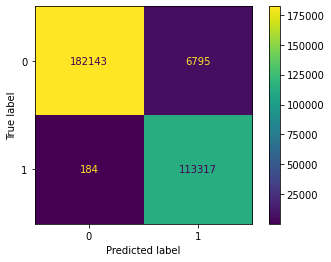

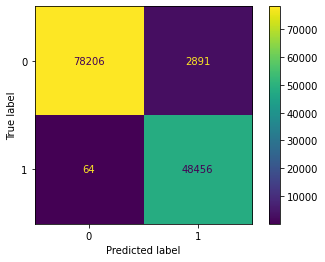

In [ ]:
# Applying Best Parameters Suggested by GridSearch

lr = LogisticRegression(C = 1.0, penalty = 'l1', solver = "saga")

lr.fit(X_train, Y_train)

lr_yp_train = lr.predict(X_train)
lr_yp_test = lr.predict(X_test)

# Model Evaluation

evaluation_parametrics("Logistic Regression Classifier", Y_train, lr_yp_train, Y_test, lr_yp_test)

In [ ]:
# Checking For Variable Importance

d1 = pd.DataFrame({'Features': list(X_train.columns), 'Variable Importance Score': list(np.around(lr.coef_[0],3))})
d1 = d1.sort_values(by = ['Variable Importance Score'], ascending = False)

feature_importance(d1)

In [ ]:
#M2 - Random Forest using GridSearchCv
grid2 = {'n_estimators': [200, 300], 'max_depth': [5,6,7,8], 'criterion': ['gini', 'entropy']}

rf = RandomForestClassifier(random_state = 42)
rf_cv = GridSearchCV(rf, grid2, cv = 3)
rf_cv.fit(X_train, Y_train)

print("Best Parameters: ", rf_cv.best_params_)
print("Accuracy: ", rf_cv.best_score_)

Best Parameters:  {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200}
Accuracy:  0.9772945949431125



-----------------------------Random Forest Classifier-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    188938
           1       0.94      1.00      0.97    113501

    accuracy                           0.98    302439
   macro avg       0.97      0.98      0.98    302439
weighted avg       0.98      0.98      0.98    302439

--------------------------------------------------------------------------
Recall on Train Data: 99.98
Specificity on Train Data: 96.39
Accuracy on Train Data: 97.72999999999999
Precision on Train Data: 94.32000000000001
F1 Score Train Data: 97.0676
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     81097
           1       0.94      1.00      0.97     48520

    accuracy           

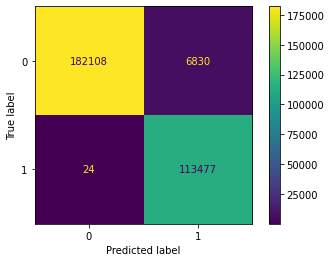

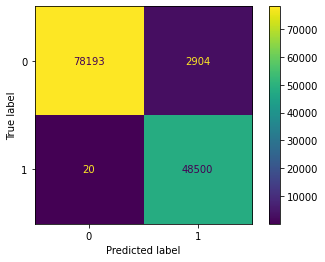

In [ ]:
# Applying Best Parameters Suggested by GridSearch

rf = RandomForestClassifier(n_estimators = 200, max_depth = 8, criterion = 'gini', random_state = 42) 

rf.fit(X_train ,Y_train)

rf_yp_train = rf.predict(X_train)
rf_yp_test = rf.predict(X_test)

# Model Evaluation

evaluation_parametrics("Random Forest Classifier", Y_train, rf_yp_train, Y_test, rf_yp_test)

In [ ]:
# Checking For Variable Importance

d2 = pd.DataFrame({'Features': list(X_train.columns), 'Variable Importance Score': list(np.around(rf.feature_importances_,3))},)

feature_importance(d2)

In [ ]:
#M3 - XGBoost using GridSearchCv
grid3 = {'gamma': [0.5, 1, 2], 'eta': [0.1, 0.2], 'n_estimators': [200, 300], 'max_depth': [5, 7, 8]}

xgb = XGBClassifier(objective = 'binary:logistic', eval_metric = "logloss", random_state = 42, use_label_encoder = False)
xgb_cv = GridSearchCV(xgb, grid3, cv = 3)
xgb_cv.fit(X_train, Y_train)

print("Best Estimators: ", xgb_cv.best_estimator_)
print("Best Parameters: ", xgb_cv.best_params_)
print("Accuracy: ", xgb_cv.best_score_)

Best Estimators:  XGBClassifier(eta=0.1, eval_metric='logloss', gamma=0.5, max_depth=5,
              n_estimators=300, random_state=42, use_label_encoder=False)
Best Parameters:  {'eta': 0.1, 'gamma': 0.5, 'max_depth': 5, 'n_estimators': 300}
Accuracy:  0.9772912884912328



-----------------------------XgBoost Classifier-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    188938
           1       0.94      1.00      0.97    113501

    accuracy                           0.98    302439
   macro avg       0.97      0.98      0.98    302439
weighted avg       0.98      0.98      0.98    302439

--------------------------------------------------------------------------
Recall on Train Data: 99.98
Specificity on Train Data: 96.38
Accuracy on Train Data: 97.72999999999999
Precision on Train Data: 94.32000000000001
F1 Score Train Data: 97.0676
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     81097
           1       0.94      1.00      0.97     48520

    accuracy                 

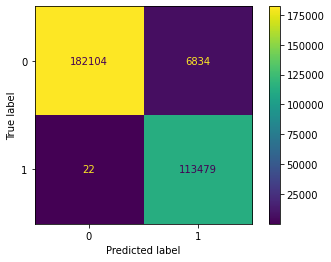

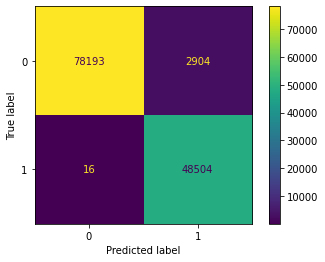

In [ ]:
# Applying Best Parameters Suggested by GridSearch

xgb = XGBClassifier(eta = 0.2, gamma = 0.5, max_depth = 5, 
                    n_estimators = 200, objective = 'binary:logistic', 
                    eval_metric = "logloss", use_label_encoder = False, random_state = 42)

xgb.fit(X_train ,Y_train)

xgb_yp_train = xgb.predict(X_train)
xgb_yp_test = xgb.predict(X_test)

# Model Evaluation

evaluation_parametrics("XgBoost Classifier", Y_train, xgb_yp_train, Y_test, xgb_yp_test)

In [ ]:
# Checking For Variable Importance

d3 = pd.DataFrame({'Features': list(X_train.columns), 'Variable Importance Score': list(np.around(xgb.feature_importances_,3))})

feature_importance(d3)

In [ ]:

from sklearn import metrics

# Predict
#pred = xgb.predict(x_test)
#xgb_yp_test
# Measure MSE error.  
mse1 = metrics.mean_squared_error(lr_yp_test,Y_test)
mse2 = metrics.mean_squared_error(rf_yp_test,Y_test)
mse3 = metrics.mean_squared_error(xgb_yp_test,Y_test)
print(mse1)
print(mse2)
print(mse3)
print(np.sqrt(mse1))
print(np.sqrt(mse2))
print(np.sqrt(mse3))

0.022797935455997283
0.022558769297237245
0.02252790914771982
0.15098985216231348
0.15019576990460565
0.15009300166136935


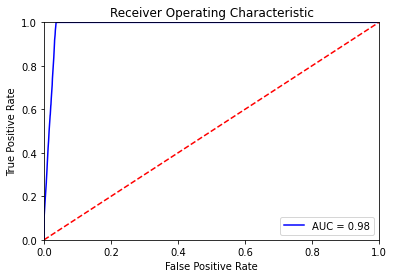

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

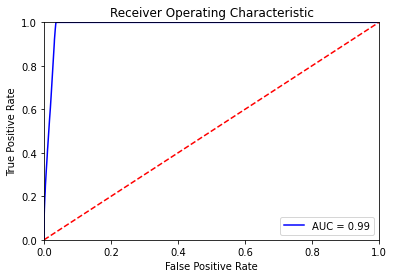

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

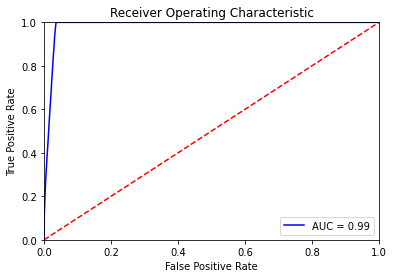

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()